# Report
20160463 성해빈

## NN, CNN algorithm
Neural networks are basically a complicated linear combination with an activation function for non-linearity.  
In basic fully connected neural networks, every input is connected to every neurons.  
Training is done by gradient descent, and pytorch calculates the gradients.  

Images have large dimensions however, so a fully connected approach easily leads to abundant weight and overfitting.  
Using the locality of an image, CNN only connects local neighbors to a neuron.  
CNN also usually use Pooling to down-sample the input, again for more simplicity.  
Gradient descent is done the same way as Fully connected neural networks, since it is more like a simpler version of Fully Connected layers.  


## Hyperparameter
Hyperparameters are basically everything except nerual network weights.  

Some parameters are fixed by the assignment : 
- architectural : kernel size, stride, number of neurons, ...
- others : SGD momemtum, batch size, learning rate, L2 weight decay

And some are not, I defined them :
- normalization of input
- initialization of weight
- validation loss checking
- loss checking frequency (every 40 iterations)
- number of iteration

## History of efforts
The performance of AlexNet almost killed me to stress. It has like about 10%~20% accuracy, and it is not minimizing the loss very well.  
First I tried Xavier Initialization, but it made almost no difference.  
I tried other AlexNet codes in the internet, and it worked quite well.  
I guess the configuration of AlexNet stated in the assignment pdf is the problem.  
For example, pytorch [code](https://github.com/pytorch/vision/blob/master/torchvision/models/alexnet.py) of Alexnet uses Dropouts BEFORE the Fully connected layers, and kernel sizes differ slightly. But this pytorch version descents quite well when I experimented it.   
I thought of changing my code in AlexNet, but I managed to stick to the architecture in the assignment pdf.  
Other models seem to learn quite well.  

resnet model and pretrained weight is from the reference in assignment pdf.  
I normalized input data.  
When training resnet18 for MNIST, I changed the depth to RGB by applying grayscale function in pytorch.

I checked validation differently this time, comparing to pa1.  
I store the minimum(best) loss value while training, and if validation loss is bigger than minimum loss value 3 times in a row when I check, then I stop training.  

First I used cpus, but as the model gets bigger and bigger, it was so painful to use only cpu. So I installed cuda and performance improved dramatically, saving my time.    

## Classification performance
Accuracy tables are at [below](#Train-and-Test) with learning curves.

the best performance in MNIST was pretrained resnet18, with 95.91% total test accuracy.  
the best performance in CIFAR was pretrained resnet44, with 88.61% total test accuracy.

AlexNet was the worst, scoring 10%-20% in both datasets. There must be a problem with the model architecture in the pdf itself.  
LeNet in MNIST gets 0% accuracy in 1~2 classes frequently, and I think that's because of the small validation set I use, leading to insufficient training.  But I didn't make a bigger validation set since it costs too much computing time to validate. When I'm lucky, I get above total 90% in LeNets too.  

I could see pretrained models have good accuracy, even if the dataset was different when training.  
Maybe it implies the similarity of images across the world.  

## Code and Learning Curve, Accuracy

### Imports

In [1]:
%matplotlib inline
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from model.resnet import resnet20, resnet32, resnet44, resnet56, resnet110

### Utility functions

In [2]:
# used to import pretrained model
def change_state_dict_remove_prefix(old_state_dict):
    # create new OrderedDict that does not contain `module.`
    from collections import OrderedDict
    new_state_dict = OrderedDict()
    for k, v in old_state_dict.items():
        name = k[7:] # remove `module.`
        new_state_dict[name] = v
    return new_state_dict

# used to export weights to txt
def change_state_dict_to_list(old_state_dict):
    # create new OrderedDict that contains list instead of Tensor
    from collections import OrderedDict
    new_state_dict = OrderedDict()
    for k, v in old_state_dict.items():
        new_state_dict[k] = v.tolist()
    return new_state_dict


# used to visualize image
def imshow(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

### Load Data

In [3]:
batch_size = 128
    
mnist_train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size, shuffle=True, num_workers=4)

mnist_test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size, shuffle=False, num_workers=4)

mnist_train_loader_rgb = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                                 torchvision.transforms.Grayscale(num_output_channels=3),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size, shuffle=True, num_workers=4)

mnist_test_loader_rgb = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                                 torchvision.transforms.Grayscale(num_output_channels=3),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size, shuffle=False, num_workers=4)


cifar_train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10('/files/', train=True, download=True,
                                        transform=torchvision.transforms.Compose([
                                            torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                        ])), 
                                        batch_size=batch_size, shuffle=True, num_workers=4)

cifar_test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10('/files/', train=False, download=True, 
                                        transform=torchvision.transforms.Compose([
                                            torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                        ])), 
                                        batch_size=batch_size, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


### Models

In [4]:
# MNIST

class MNIST_LeNet(nn.Module):
    def __init__(self):
        super(MNIST_LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5)
        self.conv2 = nn.Conv2d(20, 50, 5)
        self.fc1   = nn.Linear(50*4*4, 500)
        self.fc2   = nn.Linear(500, 10)
        
        torch.nn.init.xavier_uniform_(self.conv1.weight)
        torch.nn.init.xavier_uniform_(self.conv2.weight)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        torch.nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x, 2, stride=2)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2, stride=2)
        
        x = torch.flatten(x, 1) # reduce dimension to input to fully connected layers
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        return x

mnist_lenet = MNIST_LeNet()
mnist_lenet.name = "mnist_lenet"
    
class MNIST_AlexNet(nn.Module):
    def __init__(self):
        super(MNIST_AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 96, 5, padding=2)
        self.conv2 = nn.Conv2d(96, 256, 5, padding=2)
        self.conv3 = nn.Conv2d(256, 384, 3, padding=1)
        self.conv4 = nn.Conv2d(384, 384, 3, padding=1)
        self.conv5 = nn.Conv2d(384, 256, 3, padding=1)
        self.fc1 = nn.Linear(1024, 2304)
        self.fc2 = nn.Linear(2304, 10)

        
        torch.nn.init.xavier_uniform_(self.conv1.weight)
        torch.nn.init.xavier_uniform_(self.conv2.weight)
        torch.nn.init.xavier_uniform_(self.conv3.weight)
        torch.nn.init.xavier_uniform_(self.conv4.weight)
        torch.nn.init.xavier_uniform_(self.conv5.weight)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        torch.nn.init.xavier_uniform_(self.fc2.weight)

        
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 3, stride=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 3, stride=2)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.conv5(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 3, stride=2)
        
        x = torch.flatten(x, 1) # reduce dimension to input to fully connected layers
        
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, 0.5)
        x = self.fc2(x)
        x = F.dropout(x, 0.5)
        x = F.softmax(x, dim=1)
        
        return x

mnist_alexnet = MNIST_AlexNet()
mnist_alexnet.name = "mnist_alexnet"

mnist_resnet18_pretrained = models.resnet18(pretrained=True)
mnist_resnet18_pretrained.name = "mnist_resnet18_pretrained"


# CIFAR

class CIFAR_AlexNet(nn.Module):
    def __init__(self):
        super(CIFAR_AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 96, 5, padding=2)
        self.conv2 = nn.Conv2d(96, 256, 5, padding=2)
        self.conv3 = nn.Conv2d(256, 384, 3, padding=1)
        self.conv4 = nn.Conv2d(384, 384, 3, padding=1)
        self.conv5 = nn.Conv2d(384, 256, 3, padding=1)
        self.fc1 = nn.Linear(2304, 4096)
        self.fc2 = nn.Linear(4096, 10)

        
        torch.nn.init.xavier_uniform_(self.conv1.weight)
        torch.nn.init.xavier_uniform_(self.conv2.weight)
        torch.nn.init.xavier_uniform_(self.conv3.weight)
        torch.nn.init.xavier_uniform_(self.conv4.weight)
        torch.nn.init.xavier_uniform_(self.conv5.weight)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        torch.nn.init.xavier_uniform_(self.fc2.weight)

        
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 3, stride=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 3, stride=2)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.conv5(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 3, stride=2)
        
        x = torch.flatten(x, 1) # reduce dimension to input to fully connected layers
        
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, 0.5)
        x = self.fc2(x)
        x = F.dropout(x, 0.5)
        x = F.softmax(x, dim=1)
        
        return x

cifar_alexnet = CIFAR_AlexNet()
cifar_alexnet.name = "cifar_alexnet"


cifar_resnet20 = resnet20()
cifar_resnet20.name = "cifar_resnet20"

cifar_resnet32 = resnet32()
cifar_resnet32.name = "cifar_resnet32"

cifar_resnet44 = resnet44()
cifar_resnet44.name = "cifar_resnet44"

cifar_resnet56 = resnet56()
cifar_resnet56.name = "cifar_resnet56"

cifar_resnet110 = resnet110()
cifar_resnet110.name = "cifar_resnet110"

cifar_resnet20_pretrained = resnet20()
cifar_resnet20_pretrained.load_state_dict(change_state_dict_remove_prefix(torch.load("model/resnet20-12fca82f.th")['state_dict']))
cifar_resnet20_pretrained.name = "cifar_resnet20_pretrained"

cifar_resnet44_pretrained = resnet44()
cifar_resnet44_pretrained.load_state_dict(change_state_dict_remove_prefix(torch.load("model/resnet44-014dd654.th")['state_dict']))
cifar_resnet44_pretrained.name = "cifar_resnet44_pretrained"

cifar_resnet110_pretrained = resnet110()
cifar_resnet110_pretrained.load_state_dict(change_state_dict_remove_prefix(torch.load("model/resnet110-1d1ed7c2.th")['state_dict']))
cifar_resnet110_pretrained.name = "cifar_resnet110_pretrained"

### Train and Test

TRAIN mnist_lenet


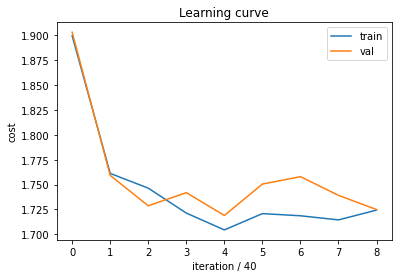

---------------------------------------------------------------------------------------------------------------------------------------------
|Average precision(%)|         0|         1|         2|         3|         4|         5|         6|         7|         8|         9|   total|
|               train|     96.22|     97.89|     94.31|     93.39|      0.00|      0.00|     98.75|     92.42|     84.28|     95.02|   76.44|
|                test|     96.84|     98.68|     94.38|     94.75|      0.00|      0.00|     98.23|     90.86|     86.45|     96.73|   76.93|
---------------------------------------------------------------------------------------------------------------------------------------------
TRAIN mnist_alexnet


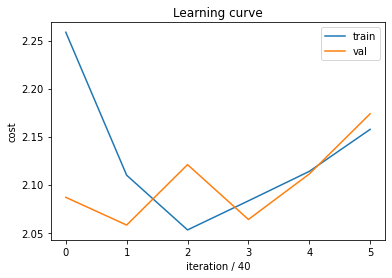

---------------------------------------------------------------------------------------------------------------------------------------------
|Average precision(%)|         0|         1|         2|         3|         4|         5|         6|         7|         8|         9|   total|
|               train|     50.36|     47.40|      1.04|     31.76|     56.26|      7.10|      9.68|     26.69|      0.10|      0.08|   23.53|
|                test|     49.29|     46.70|      0.78|     33.27|     54.89|      6.28|      9.29|     28.11|      0.00|      0.10|   23.31|
---------------------------------------------------------------------------------------------------------------------------------------------
TRAIN mnist_resnet18_pretrained


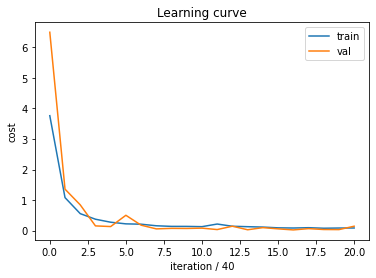

---------------------------------------------------------------------------------------------------------------------------------------------
|Average precision(%)|         0|         1|         2|         3|         4|         5|         6|         7|         8|         9|   total|
|               train|     98.87|     98.93|     96.37|     96.88|     84.34|     95.50|     96.30|     93.63|     99.28|     97.04|   95.77|
|                test|     98.88|     99.47|     97.19|     98.02|     84.42|     95.74|     95.82|     93.19|     99.38|     96.43|   95.91|
---------------------------------------------------------------------------------------------------------------------------------------------
TRAIN cifar_alexnet


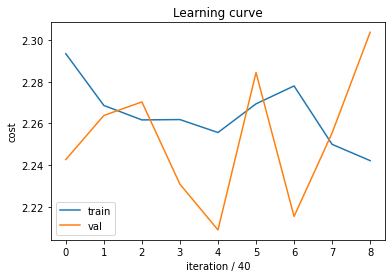

---------------------------------------------------------------------------------------------------------------------------------------------
|Average precision(%)|  airplane|automobile|      bird|       cat|      deer|       dog|      frog|     horse|      ship|     truck|   total|
|               train|      0.00|     47.86|      0.22|     14.84|      7.54|     35.04|     13.22|     35.06|     23.06|      0.22|   17.71|
|                test|      0.00|     49.90|      0.10|     15.00|      6.40|     35.70|     14.40|     33.90|     22.80|      0.30|   17.85|
---------------------------------------------------------------------------------------------------------------------------------------------
TRAIN cifar_resnet20


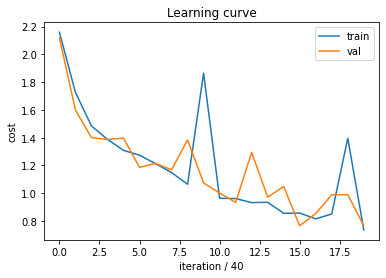

---------------------------------------------------------------------------------------------------------------------------------------------
|Average precision(%)|  airplane|automobile|      bird|       cat|      deer|       dog|      frog|     horse|      ship|     truck|   total|
|               train|     76.64|     91.66|     59.40|     20.76|     65.00|     66.74|     77.70|     93.94|     82.92|     58.96|   69.37|
|                test|     75.90|     88.80|     56.50|     20.50|     63.60|     62.20|     75.50|     92.60|     81.30|     57.20|   67.41|
---------------------------------------------------------------------------------------------------------------------------------------------
TRAIN cifar_resnet32


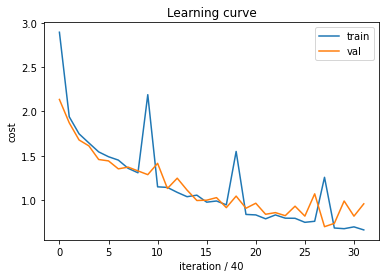

---------------------------------------------------------------------------------------------------------------------------------------------
|Average precision(%)|  airplane|automobile|      bird|       cat|      deer|       dog|      frog|     horse|      ship|     truck|   total|
|               train|     79.54|     82.02|     51.42|     37.00|     90.64|     43.96|     72.28|     63.08|     98.40|     60.48|   67.88|
|                test|     80.10|     79.70|     48.50|     32.40|     90.50|     42.10|     70.50|     58.00|     96.60|     57.50|   65.59|
---------------------------------------------------------------------------------------------------------------------------------------------
TRAIN cifar_resnet44


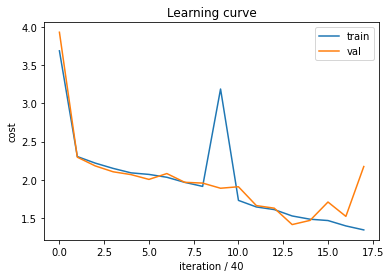

---------------------------------------------------------------------------------------------------------------------------------------------
|Average precision(%)|  airplane|automobile|      bird|       cat|      deer|       dog|      frog|     horse|      ship|     truck|   total|
|               train|     46.26|     96.72|     27.30|      9.44|     34.52|     26.02|     36.64|     22.28|     72.70|     14.46|   38.63|
|                test|     46.30|     97.60|     26.60|      7.20|     33.20|     24.80|     38.50|     21.30|     71.20|     12.10|   37.88|
---------------------------------------------------------------------------------------------------------------------------------------------
TRAIN cifar_resnet56


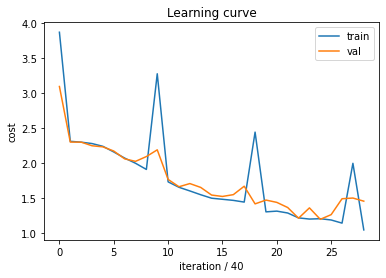

---------------------------------------------------------------------------------------------------------------------------------------------
|Average precision(%)|  airplane|automobile|      bird|       cat|      deer|       dog|      frog|     horse|      ship|     truck|   total|
|               train|     59.26|     71.10|     17.10|     37.60|     62.62|     75.74|     43.12|     59.54|     46.06|     88.04|   56.02|
|                test|     59.80|     69.50|     15.70|     34.20|     61.80|     74.10|     43.60|     57.30|     43.70|     84.70|   54.44|
---------------------------------------------------------------------------------------------------------------------------------------------
TRAIN cifar_resnet110


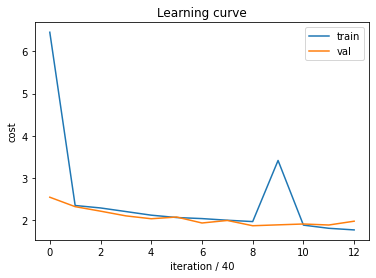

---------------------------------------------------------------------------------------------------------------------------------------------
|Average precision(%)|  airplane|automobile|      bird|       cat|      deer|       dog|      frog|     horse|      ship|     truck|   total|
|               train|     36.34|     85.62|      6.36|      6.44|      2.14|     19.90|     46.66|     48.06|     24.92|     20.34|   29.68|
|                test|     38.70|     84.50|      7.60|      5.70|      1.90|     20.40|     47.90|     51.10|     24.10|     19.00|   30.09|
---------------------------------------------------------------------------------------------------------------------------------------------
TRAIN cifar_resnet20_pretrained


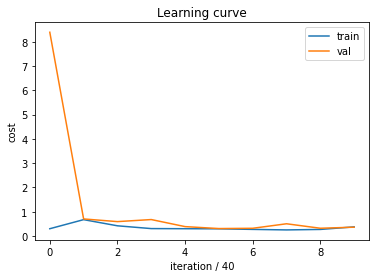

---------------------------------------------------------------------------------------------------------------------------------------------
|Average precision(%)|  airplane|automobile|      bird|       cat|      deer|       dog|      frog|     horse|      ship|     truck|   total|
|               train|     97.40|     98.56|     91.48|     92.80|     86.14|     89.74|     91.06|     94.66|     97.10|     96.64|   93.56|
|                test|     92.70|     96.20|     83.70|     82.90|     78.70|     80.90|     86.10|     89.90|     91.20|     92.00|   87.43|
---------------------------------------------------------------------------------------------------------------------------------------------
TRAIN cifar_resnet44_pretrained


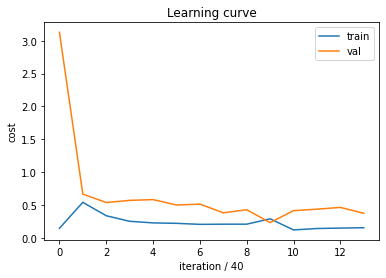

---------------------------------------------------------------------------------------------------------------------------------------------
|Average precision(%)|  airplane|automobile|      bird|       cat|      deer|       dog|      frog|     horse|      ship|     truck|   total|
|               train|     94.40|     97.26|     93.34|     95.98|     93.70|     84.42|     97.70|     98.32|     96.48|     97.40|   94.90|
|                test|     88.00|     92.70|     83.90|     86.70|     87.60|     75.50|     93.20|     95.10|     91.90|     91.50|   88.61|
---------------------------------------------------------------------------------------------------------------------------------------------
TRAIN cifar_resnet110_pretrained


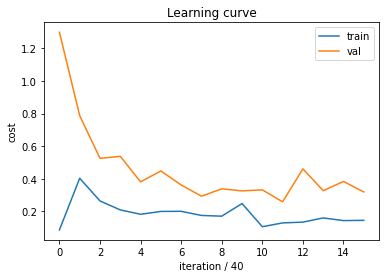

---------------------------------------------------------------------------------------------------------------------------------------------
|Average precision(%)|  airplane|automobile|      bird|       cat|      deer|       dog|      frog|     horse|      ship|     truck|   total|
|               train|     98.34|     98.24|     95.92|     88.56|     86.62|     92.64|     98.50|     91.78|     97.34|     96.28|   94.42|
|                test|     94.10|     96.00|     86.00|     73.00|     78.10|     84.90|     93.60|     86.10|     92.50|     90.20|   87.45|
---------------------------------------------------------------------------------------------------------------------------------------------


In [5]:
def train_and_test(net, train_loader, test_loader):
    net = net.cuda() # use gpu
    
    net.train() # train mode
    print("TRAIN", net.name)
    
    criterion = nn.CrossEntropyLoss().cuda()
    optimizer = optim.SGD(net.parameters(), lr=1e-1, momentum=0.9, weight_decay=1e-4)

    check_freq = 40
    train_loss_history = []
    train_loss = 0.0
    val_loss_history = []
    
    val_inputs, val_labels = iter(test_loader).next() #validate with only first batch of test set
    val_inputs = val_inputs.cuda()
    val_labels = val_labels.cuda()
    val_inc_count = 0 # val cost increase count
    val_best = None # best val loss
    val_break = False # validation break
    
    for epoch in range(5):
        if val_break == True:
            break

        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            inputs = inputs.cuda()
            labels = labels.cuda()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            if i % check_freq == check_freq-1:
                train_loss_history.append((train_loss / check_freq)) # loss for 1 batch size : 128 images
                train_loss = 0.0


                with torch.no_grad(): # validation loss check

                    net.eval() # eval mode
                    outputs = net(val_inputs)
                    val_loss = criterion(outputs, val_labels)
                    val_loss_history.append(val_loss.item())
                    
                    if val_best == None:
                        val_best = val_loss
                    else:
                        if val_best > val_loss:
                            val_best = val_loss
                            val_inc_count = 0
                        else:
                            val_inc_count += 1
                    
                    if val_inc_count > 3: # if val loss is bigger than best val loss more than 3 times, stop training
                        val_break = True
                        break

                net.train() # train mode
    
    plt.title("Learning curve")
    plt.xlabel("iteration / " + str(check_freq))
    plt.ylabel("cost")
    plt.plot(train_loss_history, label='train')
    plt.plot(val_loss_history, label='val')
    plt.legend()
    plt.show()
    
   

    '''
    # Test Example data
    
    net.eval() # eval mode

    dataiter = iter(test_loader)
    inputs, labels = dataiter.next() #first data
    
    inputs = inputs.cuda()
    labels = labels.cuda()

    imshow(torchvision.utils.make_grid(inputs))

    output = net(inputs)

    print("TRUTH", labels)
    print("INFERENCE", torch.max(output, dim=1).indices)
    '''

    # Accuracy
    
    net.eval() # eval mode
    
    with torch.no_grad():
        train_correct = [0 for _ in range(10)]
        train_total = [0 for _ in range(10)]
        test_correct = [0 for _ in range(10)]
        test_total = [0 for _ in range(10)]
        
        for data in train_loader:
            inputs, labels = data
            inputs = inputs.cuda()
            labels = labels.cuda()
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            for i in range(10): # each class
                train_total[i] += (i == labels).sum().item()
                train_correct[i] += torch.logical_and((i == labels), (i == predicted)).sum().item()
        
        for data in test_loader:
            inputs, labels = data
            inputs = inputs.cuda()
            labels = labels.cuda()
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            for i in range(10): # each class
                test_total[i] += (i == labels).sum().item()
                test_correct[i] += torch.logical_and((i == labels), (i == predicted)).sum().item()
    
        print("-"*141)
        if 'mnist' in net.name:
            print("|{:>20s}|{:10d}|{:10d}|{:10d}|{:10d}|{:10d}|{:10d}|{:10d}|{:10d}|{:10d}|{:10d}|{:>8s}|".format("Average precision(%)", *range(10),'total'))
        else:
            print("|{:>20s}|{:>10s}|{:>10s}|{:>10s}|{:>10s}|{:>10s}|{:>10s}|{:>10s}|{:>10s}|{:>10s}|{:>10s}|{:>8s}|".format("Average precision(%)", 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck', 'total'))
        print("|{:>20s}|{:10.2f}|{:10.2f}|{:10.2f}|{:10.2f}|{:10.2f}|{:10.2f}|{:10.2f}|{:10.2f}|{:10.2f}|{:10.2f}|{:8.2f}|".format("train", *[100*x/y for (x,y) in zip(train_correct, train_total)], 100 * sum(train_correct) / sum(train_total)))
        print("|{:>20s}|{:10.2f}|{:10.2f}|{:10.2f}|{:10.2f}|{:10.2f}|{:10.2f}|{:10.2f}|{:10.2f}|{:10.2f}|{:10.2f}|{:8.2f}|".format("test", *[100*x/y for (x,y) in zip(test_correct, test_total)], 100 * sum(test_correct) / sum(test_total)))
        print("-"*141)



train_and_test(mnist_lenet, mnist_train_loader, mnist_test_loader)
train_and_test(mnist_alexnet, mnist_train_loader, mnist_test_loader)
train_and_test(mnist_resnet18_pretrained, mnist_train_loader_rgb, mnist_test_loader_rgb)

train_and_test(cifar_alexnet, cifar_train_loader, cifar_test_loader)
train_and_test(cifar_resnet20, cifar_train_loader, cifar_test_loader)
train_and_test(cifar_resnet32, cifar_train_loader, cifar_test_loader)
train_and_test(cifar_resnet44, cifar_train_loader, cifar_test_loader)
train_and_test(cifar_resnet56, cifar_train_loader, cifar_test_loader)
train_and_test(cifar_resnet110, cifar_train_loader, cifar_test_loader)
train_and_test(cifar_resnet20_pretrained, cifar_train_loader, cifar_test_loader)
train_and_test(cifar_resnet44_pretrained, cifar_train_loader, cifar_test_loader)
train_and_test(cifar_resnet110_pretrained, cifar_train_loader, cifar_test_loader)



### Export parameters
the parameter files are too big (800MB), so I can't upload it in LMS.  
Instead I will leave a [link](https://drive.google.com/file/d/1d4OjeRXLJUGGg2Iytgj_jT2ljSuhQP18/view?usp=sharing) to the file that has the parameters, with below code

In [6]:
import json

param_file = open("params.txt", "w")

param_list = []
param_list.append(change_state_dict_to_list(mnist_lenet.state_dict()))
param_list.append(change_state_dict_to_list(mnist_alexnet.state_dict()))
param_list.append(change_state_dict_to_list(mnist_resnet18_pretrained.state_dict()))
param_list.append(change_state_dict_to_list(cifar_alexnet.state_dict()))
param_list.append(change_state_dict_to_list(cifar_resnet20.state_dict()))
param_list.append(change_state_dict_to_list(cifar_resnet32.state_dict()))
param_list.append(change_state_dict_to_list(cifar_resnet44.state_dict()))
param_list.append(change_state_dict_to_list(cifar_resnet110.state_dict()))
param_list.append(change_state_dict_to_list(cifar_resnet20_pretrained.state_dict()))
param_list.append(change_state_dict_to_list(cifar_resnet44_pretrained.state_dict()))
param_list.append(change_state_dict_to_list(cifar_resnet110_pretrained.state_dict()))

param_file.write(json.dumps(param_list))

param_file.close()